# Item Pricing Recommender (XGBoost Solution)

## Using XGBoost in SageMaker (with Hyperparameter Tuning)

## 1. Imports and installations needed

In [34]:
%matplotlib inline

import os
from pprint import pprint
import sys

import time
from time import gmtime, strftime

import numpy as np
from numpy import genfromtxt
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import sklearn.model_selection
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from itertools import islice
import seaborn as sns
import re

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
from sagemaker.predictor import csv_serializer


In [7]:
!pip install textblob 
!pip install category_encoders
!pip install shap
!pip install smdebug 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [35]:
from textblob import TextBlob
from category_encoders import BinaryEncoder, OneHotEncoder
import shap
from smdebug.trials import create_trial

### We want to print full np.array and display all columns in a dataframe

In [5]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', None)

### Create SageMaker session and get the IAM role

In [21]:
session = sagemaker.Session()
role = get_execution_role()

## 1. Download the data and define the functions needed to preprocess it

In [20]:
dframe=pd.read_csv('../data/train.tsv', sep='\t')

# As we did in the data exploration part, we expand the categories to their full hierarchy, one per column
dframe = dframe.join(dframe['category_name'].str.split('/', expand=True).add_prefix('cat_').fillna(np.nan))
dframe.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_0,cat_1,cat_2,cat_3,cat_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN,NaN


In [21]:
def dropColumns(df, columns):
    """ Drops listed columns and returns the updated dataframe

    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    result =  all(elem in df.columns  for elem in columns)
    if result:
        df.drop(columns,axis=1,inplace=True)
        
    else:
        print('Some of the columns are not in the dataframe')
        
    return df

In [22]:
def dropMissingValues(df, columns):
    """ Drops rows with NaNs in the given columns and returns the updated dataframe
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    df.dropna(subset=columns, inplace=True)
    
    return df

In [23]:
def replaceMissingValues(df, columns, value):
    """ Replaces NaNs with the given value in the given columns and returns the updated dataframe
 
    :param df: input dataframe
    :param columns: list of columns
    :param value: the replacement value
    :return: processed dataframe
    """
    for column in columns:
        df[column] = df[column].fillna(value)
    
    return df

In [24]:
def dropZeroPrice(df):
    """ Drops rows with price equal to 0 and returns updated dataframe
 
    :param df: input dataframe
    :return: processed dataframe
    """
    
    df = df[df.price>0]
    
    return df

In [25]:
def labelEncoding(df, columns):
    """ Encodes the given columns
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    for column in columns:
        df[column + "_cat"] = df[column].astype('category').cat.codes
    return df

In [26]:
def sentimentAnalysis(df, columns):
    """ Computes the polarity of the sentiment of the given text columns
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    for column in columns:
        df[column + '_tb'] = df[column].map(lambda ps: TextBlob(ps).sentiment.polarity)
    return df

In [27]:
def correlationPlot(df):
    """ Plots a correlation diagram.

    :param df: input dataframe
    :return: 
    """
    corr = df.corr()

    f,ax = plt.subplots(figsize=(19,16))
    sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
    plt.show()

## 2. Preprocess data

In [28]:
dframe = dropColumns(df=dframe, columns=['category_name', 'cat_0', 'cat_1', 'cat_3', 'cat_4'])
dframe.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Blouse
3,3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,Necklaces


In [29]:
print(dframe.columns[dframe.isnull().any()]) # Check again columns with nulls
no_cat_2_rows = dframe[dframe['cat_2'].isnull()].count()['train_id']
print(no_cat_2_rows) # Check number of rows with no cat_2

Index(['brand_name', 'item_description', 'cat_2'], dtype='object')
6327


In [30]:
# Drop the rows with now cat_2 (alternatively we could have included them in "Other")

initial = dframe.shape[0]
dframe = dropMissingValues(df=dframe, columns=['cat_2'])
assert(initial - dframe.shape[0]) == no_cat_2_rows

In [31]:
# Replace missing values in brand_name and item_description with empty

dframe = replaceMissingValues(dframe, ['brand_name', 'item_description'], '')
dframe.columns[dframe.isnull().any()]

Index([], dtype='object')

In [32]:
# Check items with price equal to 0, grouped by cat_2 and ordered in descendent order

dframe[dframe.price == 0].groupby(["cat_2"])["price"].count().sort_values(ascending=False)

cat_2
T-Shirts                   31
Shoes                      30
Other                      26
Face                       26
Pants, Tights, Leggings    25
                           ..
Household Cleaners          1
Ink & Toner                 1
Instrument Accessories      1
Writing                     1
Hair & Scalp Treatments     1
Name: price, Length: 198, dtype: int64

In [33]:
# We drop those items

dframe = dropZeroPrice(dframe)
dframe[dframe.price == 0].groupby(["cat_2"])["price"].count().sort_values(ascending=False)

Series([], Name: price, dtype: int64)

In [34]:
# More preprocessing, let's make sure again the type of each column

dframe.dtypes

train_id               int64
name                  object
item_condition_id      int64
brand_name            object
price                float64
shipping               int64
item_description      object
cat_2                 object
dtype: object

In [35]:
# And have a look of the content of our dataframe

dframe.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,,10.0,1,No description yet,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Blouse
3,3,Leather Horse Statues,1,,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home Décor Accents
4,4,24K GOLD plated rose,1,,44.0,0,Complete with certificate of authenticity,Necklaces


In [36]:
# Let's apply a binary encoder to the item_condition_id

enc = BinaryEncoder(cols=['cat_2', 'item_condition_id']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,No description yet,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [37]:
# and a one hot encoder to the shipping (we got only 0 or 1)

enc = OneHotEncoder(cols=['shipping']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,0,No description yet,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [38]:
dframe['item_description'] = dframe['item_description'].replace(['No description yet'],'') 

dframe.head(5)

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [39]:
# binary-encode the brand_name

brand_values = dframe.brand_name.unique().astype(str) # Let's see how many and which the are
print(len(brand_values))
for n in sorted(brand_values):
    print(n)

enc = BinaryEncoder(cols=['brand_name']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

4790

!iT Jeans
% Pure
10.Deep
191 Unlimited
1byone
21men
24/7 Comfort Apparel
2K Games
2XU
3.1 Phillip Lim
3M®
47
47 Brand
5.11 Tactical
525 America
5th & Ocean
7 Diamonds
7 For All Mankind®
8732 Apparel
90 Degree By Reflex
A Bathing Ape
A Pea In The Pod
A Plus Child Supply
A Wish Come True
A&A Optical
A&E
A&R Sports
A+D
A-Shirt
A. Byer
A.B.S. by Allen Schwartz
A.D. Sutton & Sons
A.K.A
A.L.C.
A.P.C.
A/X Armani Exchange
AA Aquarium
AB Studio
ABC Studios
ABS by Allen Schwartz
AC/DC
ACCEL
ACDelco
ADAM
AERIN
AG Adriano Goldschmied
AGB
AGUADECOCO
AKA New York
AKIRA
AKOO
ALDO
ALEX AND ANI
ALLOY
ALO Yoga
AMD
AMIA
ANAMA
AND
AND1
ANDREA FENZI
ANGL
API
ARCONA
ART
ASICS
ASOLO
ASOS
ASSETS by Sara Blakely
ASTR
ASUS
AT&T
AT-A-GLANCE
ATI Technologies
AX Paris
Abbott
Abercrombie & Fitch
Able provider
Abu Garcia
Acacia Swimwear
Academy
Accessory Collective
Accessory Innovations
Accessory Power
Accessory Workshop
Accutron
Acer
Acne Jeans
Acne Studios
Acorn
Acrobat
Act
Active
Activision
Actron®
Acure
Ad

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [40]:
# Finally, we compute the polarity of the sentiment analysis for item_description and name

dframe = sentimentAnalysis(dframe, ['item_description', 'name'])

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10,item_description_tb,name_tb
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.0
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0,0.900000,0.0
2,2,AVA-VIV Blouse,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1,0.136250,0.0
3,3,Leather Horse Statues,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0,0.232121,0.0
4,4,24K GOLD plated rose,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1,0.100000,0.6


In [41]:
# We will deirve two more features, the lengths of name and item_description, on which we apply the standard scaler
# Finally, we dispose of name and item_description columns

dframe['name_len'] = dframe['name'].str.len()
dframe['item_description_len'] = dframe['item_description'].str.len()

scaler = StandardScaler()
dframe.name_len = scaler.fit_transform(dframe.name_len.to_numpy().reshape(-1, 1))
dframe.item_description_len = scaler.fit_transform(dframe.item_description_len.to_numpy().reshape(-1, 1))
dframe = dropColumns(dframe, ['name', 'item_description', 'train_id'])

dframe.head()

,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10,item_description_tb,name_tb,name_len,item_description_len
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.0,1.004765,-0.825897
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.900000,0.0,0.677383,0.246388
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.136250,0.0,-1.286908,-0.118645
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.232121,0.0,-0.523017,0.160834
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.100000,0.6,-0.632144,-0.592048


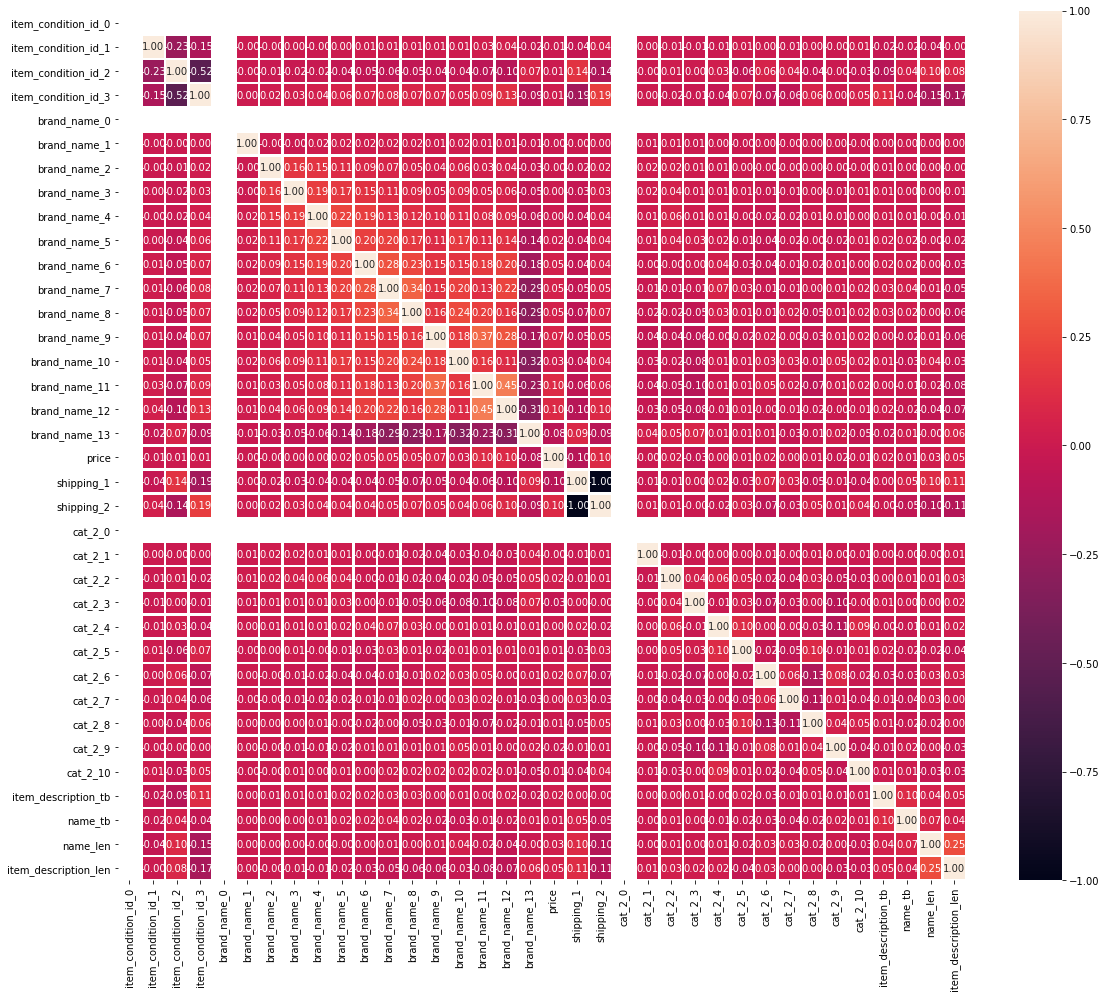

In [42]:
# Before proceeding with the XGBoost training, let's make sure parameter correlation is low

correlationPlot(dframe)

## 3. Prepare training, validation and test data

In [43]:
def splitData(df, test_size, y_column):
    """ Splits data in train and test.

    :param df: input dataframe
    :test_size: float
    :y_column: list of columns to be predicted
    :return: 4 dataframes
    """
    
    X_columns = [x for x in df.columns if x not in y_column]
    X_train, X_test, y_train, y_test = train_test_split(df[X_columns], df[y_column],
                                                        test_size=test_size)
    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = splitData(df=dframe, test_size=0.1, y_column=['price'])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1327812, 35) (1327812, 1) (147535, 35) (147535, 1)


In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1195030, 35) (1195030, 1) (132782, 35) (132782, 1)


## 4. Uploading the data files to S3

In [23]:
data_dir = '../data'
prefix = 'capstone-xgboost-tuning'
bucket_name = 'octa-capstone'

In [47]:
# Save first locally the data files to be uploaded to S3

X_test.to_csv(os.path.join(data_dir, 'price_test_xgb.csv'), header=False, index=False)

pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'price_validation_xgb.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'price_train_xgb.csv'), header=False, index=False)

y_test.to_csv(os.path.join(data_dir, 'y_price_test_xgb.csv'), header=False, index=False)

In [24]:
# Upload files to S3

test_location = session.upload_data(os.path.join(data_dir, 'price_test_xgb.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'price_validation_xgb.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'price_train_xgb.csv'), key_prefix=prefix)

## 5. Build the XGBoost model and train it

In [49]:
container = get_image_uri(session.boto_region_name, 'xgboost', 'latest')

training_params = {}

training_params['RoleArn'] = role

training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + bucket_name + "/" + prefix + "/output"
}

training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

training_params['StaticHyperParameters'] = {
    "gamma": "4",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [50]:
# We set up the hyperparameter tuning job, for the following ones: eta, max_depth and min_child_weight

tuning_job_config = {
    "ParameterRanges": {
    "CategoricalParameterRanges": [],
    "ContinuousParameterRanges": [
        {
            "MaxValue": "0.5",
            "MinValue": "0.05",
            "Name": "eta"
        },
    ],
    "IntegerParameterRanges": [
        {
            "MaxValue": "12",
            "MinValue": "3",
            "Name": "max_depth"
        },
        {
            "MaxValue": "8",
            "MinValue": "2",
            "Name": "min_child_weight"
        }
    ]},
    "ResourceLimits": {
        "MaxNumberOfTrainingJobs": 20,
        "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
        "MetricName": "validation:rmse",
        "Type": "Minimize"
    }
  }

In [51]:
# We execute the tuning job

tuning_job_name = "tuning-job" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

session.sagemaker_client.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                                           HyperParameterTuningJobConfig = tuning_job_config,
                                                           TrainingJobDefinition = training_params)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:hyper-parameter-tuning-job/tuning-job2021-02-09-08-48-35',
 'ResponseMetadata': {'RequestId': '53a0bfc0-e0f3-4d11-b36e-8b8fc472064e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '53a0bfc0-e0f3-4d11-b36e-8b8fc472064e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Tue, 09 Feb 2021 08:48:35 GMT'},
  'RetryAttempts': 0}}

In [52]:
session.wait_for_tuning_job(tuning_job_name)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


{'HyperParameterTuningJobName': 'tuning-job2021-02-09-08-48-35',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:hyper-parameter-tuning-job/tuning-job2021-02-09-08-48-35',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'validation:rmse'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 20,
   'MaxParallelTrainingJobs': 3},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'max_depth',
     'MinValue': '3',
     'MaxValue': '12',
     'ScalingType': 'Auto'},
    {'Name': 'min_child_weight',
     'MinValue': '2',
     'MaxValue': '8',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'eta',
     'MinValue': '0.05',
     'MaxValue': '0.5',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': []}},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'validation:rmse',
   'early_stopping_rounds': '10',
   'gamma

In [53]:
# We build the model by using the best training job.

tuning_job_info = session.sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job_name = tuning_job_info['BestTrainingJob']['TrainingJobName']
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [54]:
model_name = best_training_job_name + "-model"

primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## 6. Testing the model

In [55]:
# We will use SageMaker Batch Transform functionality.

transform_job_name = 'price-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

transform_request = \
{
    "TransformJobName": transform_job_name,
    
    "ModelName": model_name,
    
    "MaxConcurrentTransforms": 1,
    
    "MaxPayloadInMB": 6,
    
    "BatchStrategy": "MultiRecord",
    
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-transform/".format(bucket_name, prefix)
    },
    
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

In [56]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = session.wait_for_transform_job(transform_job_name)

.............................................................!


## 7. Analyzing the results

In [57]:
# Get results locally

transform_output = "s3://{}/{}/batch-transform/".format(bucket_name, prefix)
transform_output

's3://octa-capstone/capstone-xgboost-tuning/batch-transform/'

In [58]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://octa-capstone/capstone-xgboost-tuning/batch-transform/price_test_xgb.csv.out to ../data/price_test_xgb.csv.out
download: s3://octa-capstone/capstone-xgboost-tuning/batch-transform/price_test2.csv.out to ../data/price_test2.csv.out
download: s3://octa-capstone/capstone-xgboost-tuning/batch-transform/price_test_0.csv.out to ../data/price_test_0.csv.out


Text(0.5, 1.0, 'Predicted Price vs Test Price')

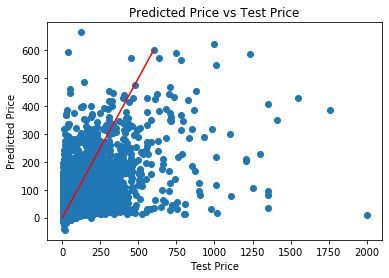

In [59]:
# We create a scatter plot of the predicted y and the test y

y_pred = pd.read_csv(os.path.join(data_dir, 'price_test_xgb.csv.out'), header=None)
y_test = pd.read_csv(os.path.join(data_dir, 'y_price_test_xgb.csv'), header=None)

plt.scatter(y_test, y_pred)
plt.plot([0, 600], [0, 600], 'r-')
plt.xlabel("Test Price")
plt.ylabel("Predicted Price")
plt.title("Predicted Price vs Test Price")

In [60]:
def rmse(y_test, y_pred): 
    """ Computes RMSE

    :param y_test: y test
    :param y_pred: y predicted
    :return: RMSE value
    """
    return np.sqrt(np.mean(np.square(y_pred - y_test)))[0]


In [61]:
def rmsle(y_test, y_pred): 
    """ Computes RMSLE

    :param y_test: y test
    :param y_pred: y predicted
    :return: RMSLE value
    """
    return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_test + 1))))[0]


In [62]:
def mape(y_test, y_pred): 
    """ Computes MAPE

    :param y_test: y test
    :param y_pred: y predicted
    :return: MAPE value
    """
    return np.mean(np.abs((y_test - y_pred) / y_test))[0]


In [63]:
def mae(y_test, y_pred): 
    """ Computes MAE

    :param y_test: y test
    :param y_pred: y predicted
    :return: MAE value
    """
    return np.mean(np.abs(y_test - y_pred))[0]


In [76]:
print('RMSE = {}'.format(rmse(y_test, y_pred)))
print('RMSLE = {}'.format(rmsle(y_test, y_pp)))
print('MAPE = {}'.format(mape(y_test, y_pred)))
print('MAE = {}'.format(mae(y_test, y_pred)))

RMSE = 30.700245425127
RMSLE = 0.6197910795554784
MAPE = 0.704114087078729
MAE = 13.55730238937099


## 9. Predict a result

In [116]:
vect = np.array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.13636364,  0.        , -1.39603544, -0.6576943 ])


xgb = sagemaker.estimator.Estimator.attach('tuning-job2021-02-06-18-02-55-016-d52bfdda')

xgb.set_hyperparameters(max_depth=12,
                        eta=0.10124202006911284,
                        gamma=4,
                        min_child_weight=5,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=500)

xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')



2021-02-06 18:54:03 Starting - Preparing the instances for training
2021-02-06 18:54:03 Downloading - Downloading input data
2021-02-06 18:54:03 Training - Training image download completed. Training in progress.
2021-02-06 18:54:03 Uploading - Uploading generated training model
2021-02-06 18:54:03 Completed - Training job completed
-----------------!

In [118]:
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = 'tuning-job2021-02-06-18-02-55-016-d52bf-2021-02-06-22-44-31-055',
                                                ContentType = 'text/csv',
                                                Body = ','.join(map(str, vect)))
result = response['Body'].read().decode("utf-8")
pprint(result)

'18.9463310242'


## 10. Results characterisation

In [77]:
training_job_info

{'TrainingJobName': 'tuning-job2021-02-09-08-48-35-013-bc35fcb6',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:training-job/tuning-job2021-02-09-08-48-35-013-bc35fcb6',
 'TuningJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:hyper-parameter-tuning-job/tuning-job2021-02-09-08-48-35',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://octa-capstone/capstone-xgboost-tuning/output/tuning-job2021-02-09-08-48-35-013-bc35fcb6/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'_tuning_objective_metric': 'validation:rmse',
  'early_stopping_rounds': '10',
  'eta': '0.08593727438063993',
  'gamma': '4',
  'max_depth': '12',
  'min_child_weight': '7',
  'num_round': '200',
  'objective': 'reg:linear',
  'subsample': '0.8'},
 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*

In [135]:
model_artifacts

's3://octa-capstone/capstone-xgboost-tuning/output/tuning-job2021-02-09-08-48-35-013-bc35fcb6/output/model.tar.gz'

In [26]:
container = get_image_uri(session.boto_region_name, "xgboost", repo_version="0.90-2")

save_interval = 5
hyperparameters={
    "max_depth": "12",
    "eta": "0.08593727438063993",
    "gamma": "4",
    "min_child_weight": "7",
    "subsample": "0.8",
    "silent": "0",
    "objective": "reg:squarederror",
    "early_stopping_rounds": "10",
    "num_round": "500",
}

xgboost_estimator = Estimator(
    role=role,
    base_job_name='shap-xgboost',
    hyperparameters=hyperparameters,
    train_instance_count=1,
    train_instance_type='ml.c5.18xlarge',
    image_uri=container,
    train_max_run=3600,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path="s3://" + bucket_name + "/" + prefix + "/output",
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [27]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(train_location, content_type="csv")

validation_input = TrainingInput(val_location, content_type="csv")

xgboost_estimator.fit(
    {"train": train_input, "validation": validation_input},
    wait=True
)

2021-02-10 09:38:54 Starting - Starting the training job...
2021-02-10 09:39:20 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport-1612949934: InProgress
......
2021-02-10 09:40:20 Starting - Preparing the instances for training......
2021-02-10 09:41:25 Downloading - Downloading input data
2021-02-10 09:41:25 Training - Downloading the training image...
2021-02-10 09:41:41 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is '

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Training seconds: 3767
Billable seconds: 3767


In [28]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:processing-job/shap-xgboost-2021-02-10-09-lossnotdecreasing-3d20f803',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 2, 10, 10, 44, 13, 256000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1612949934',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:491446337008:processing-job/shap-xgboost-2021-02-10-09-profilerreport-1612949934-118ecac6',
  'RuleEvaluationStatus': 'Stopped',
  'LastModifiedTime': datetime.datetime(2021, 2, 10, 10, 43, 8, 915000, tzinfo=tzlocal())}]

In [29]:
import time
from time import gmtime, strftime

In [30]:
job_name = xgboost_estimator.latest_training_job.name
client = xgboost_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

In [32]:
print("Training job name" + job_name)

Training job nameshap-xgboost-2021-02-10-09-38-54-254


In [39]:
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-02-10 10:54:08.977 ip-172-16-22-64:70645 INFO s3_trial.py:42] Loading trial debug-output at path s3://octa-capstone/capstone-xgboost-tuning/output/shap-xgboost-2021-02-10-09-38-54-254/debug-output


In [40]:
trial.tensor_names()


[2021-02-10 10:54:09.810 ip-172-16-22-64:70645 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-02-10 10:54:10.829 ip-172-16-22-64:70645 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f28',
 'average_shap/f29',
 'average_shap/f3',
 'average_shap/f30',
 'average_shap/f31',
 'average_shap/f32',
 'average_shap/f33',
 'average_shap/f34',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_im

In [41]:
trial.tensor("train-rmse").steps()

[0, 5, 10, 15, 20]

In [42]:
type(trial.tensor("train-rmse").value(0))

numpy.ndarray

In [81]:
MAX_PLOTS = 35

feature_names = ['item_condition_id_0', 'item_condition_id_1', 'item_condition_id_2', 'item_condition_id_3', 'brand_name_0', 'brand_name_1', 'brand_name_2', 'brand_name_3', 'brand_name_4', 'brand_name_5', 'brand_name_6', 'brand_name_7', 'brand_name_8', 'brand_name_9', 'brand_name_10', 'brand_name_11', 'brand_name_12', 'brand_name_13', 'shipping_1', 'shipping_2', 'cat_2_0', 'cat_2_1', 'cat_2_2', 'cat_2_3', 'cat_2_4', 'cat_2_5', 'cat_2_6', 'cat_2_7', 'cat_2_8', 'cat_2_9', 'cat_2_10', 'item_description_tb', 'name_tb', 'name_len', 'item_description_len']

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which we have data and fetches the values.
    Returns the set of steps and the values.
    
    :param trial: trial
    :param tname: trial_name
    :return: steps and values
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    """
    Matches the feature name with the tensor name
        
    :param tensor_name: tensor name as string
    :param feature_names: feature names
    :return: tensor name or feature names if parsable
    """
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6), feature_names=feature_names):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    
    :param trial: trial
    :param collection_name: collection name
    :param regex: regex used to match tensors with
    :param figsize: size of the plot
    :param feature_names: names of the feature to depict as legend
    :return:
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name, feature_names))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

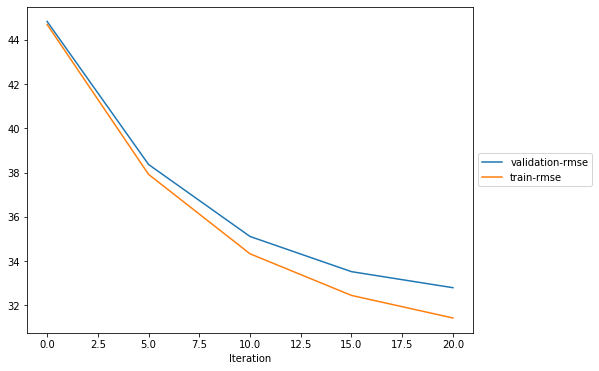

In [58]:
# Evolution of train and validation RMSE

plot_collection(trial, "metrics")

In [83]:
def plot_feature_importance(trial, importance_type="weight", feature_names=feature_names):
    """
    Selects importance type used for the features plot
    
    :param trial: trial
    :param importance_type: importance type, one of "weight", "gain", "cover", "total_gain", "total_cover"
    :param feature_names: names of the feature to depict as legend
    :return:
    """
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

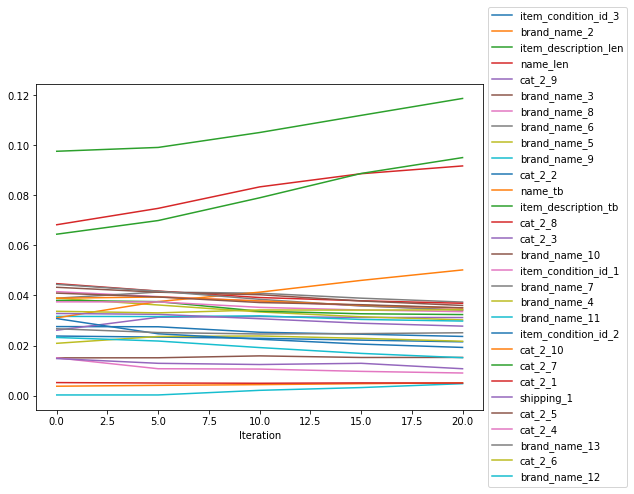

In [84]:
# Plot by weight

plot_feature_importance(trial)

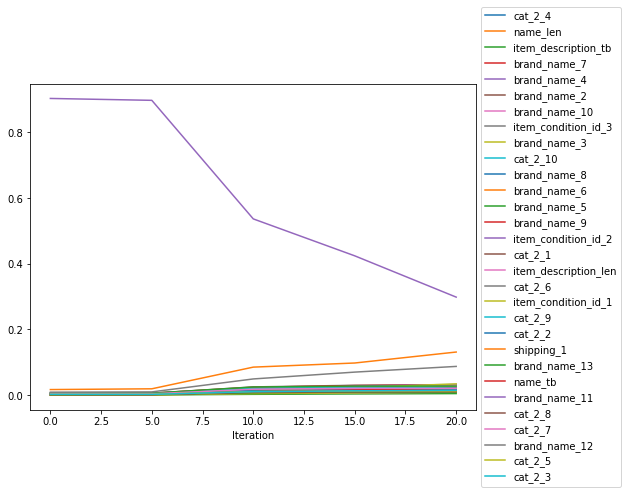

In [85]:
# Plot by cover

plot_feature_importance(trial, importance_type="cover")

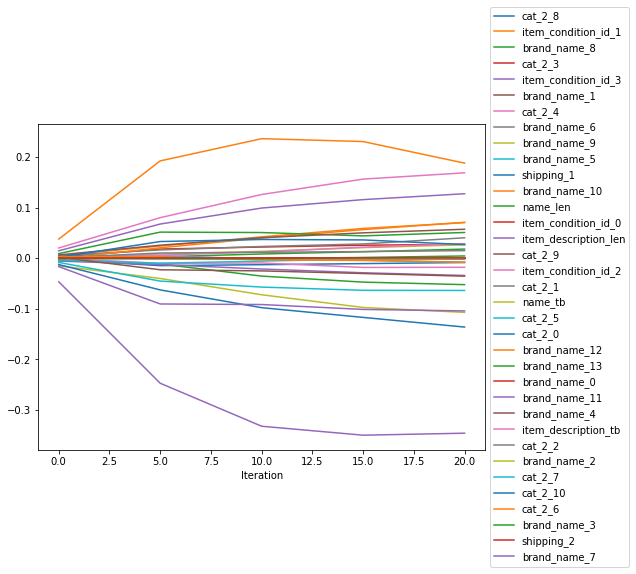

In [86]:
# Plot by weight average_shap

plot_collection(trial,"average_shap")

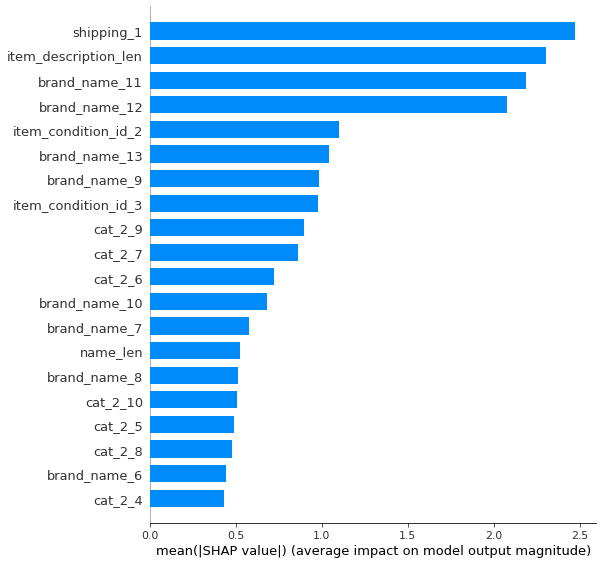

In [87]:
# Aggregate bar plot of the mean absolute SHAP value for each feature

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [88]:
# We will use this value further

shap_base_value

22.736925

In [72]:
X_train = genfromtxt('../data/price_train_xgb.csv', delimiter=',')
assert(len(X_train)) == len(shap_no_base)

numpy.ndarray

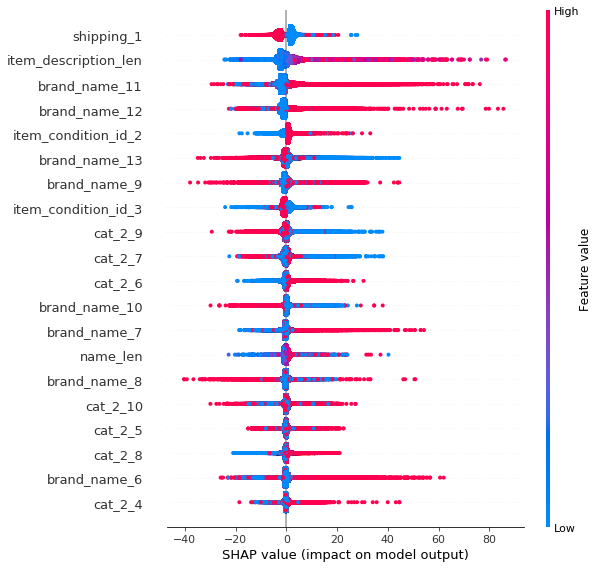

In [82]:
# Global explanations

shap.summary_plot(shap_no_base, X_train[:,1:], feature_names=feature_names)

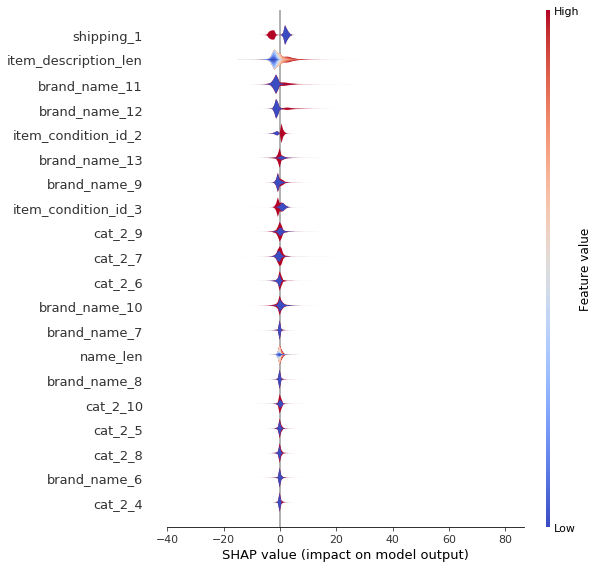

In [89]:
shap.summary_plot(shap_no_base, X_train[:,1:], feature_names=feature_names, plot_type="layered_violin", color='coolwarm')

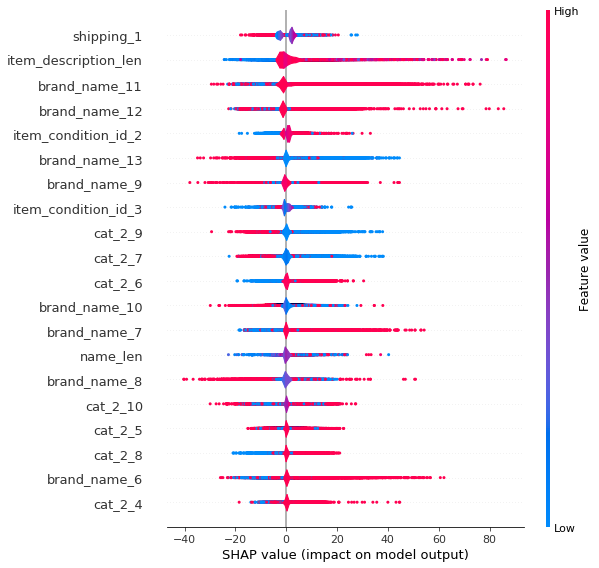

In [90]:
shap.summary_plot(shap_no_base, X_train[:,1:], feature_names=feature_names, plot_type="violin")

In [95]:
# Local explanation - force plot

shap.initjs()

shap.force_plot(shap_base_value, shap_no_base[100, :], X_train[100, 1:], feature_names=feature_names,\
                link="logit", matplotlib=False)

## 11. Clean up

In [119]:
# Delete endpoint

boto3.client('sagemaker').delete_endpoint(EndpointName=xgb_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'ResponseMetadata': {'RequestId': 'db5ba97c-ae86-48d9-b960-e29b1afedecf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'db5ba97c-ae86-48d9-b960-e29b1afedecf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 06 Feb 2021 22:53:15 GMT'},
  'RetryAttempts': 0}}

In [ ]:
# Remove all local files and directory

!rm $data_dir/*